**Project Name** -
Trader Performance vs Market Sentiment

**Objective**

Analyze how market sentiment (Fear/Greed) relates to trader behavior and performance on Hyperliquid. Our goal is to uncover patterns that could inform smarter trading strategies.

Step 1 - Data Preperation

In [ ]:
import pandas as pd

# Load the datasets
fear_greed_df = pd.read_csv('fear_greed_index.csv')
historical_df = pd.read_csv('historical_data.csv')

# Document basic statistics
print(f"Fear & Greed: {fear_greed_df.shape[0]} rows, {fear_greed_df.shape[1]} columns")
print(f"Historical Data: {historical_df.shape[0]} rows, {historical_df.shape[1]} columns")

# Check for missing values and duplicates
print("Fear & Greed Missing:", fear_greed_df.isnull().sum().sum())
print("Historical Data Duplicates:", historical_df.duplicated().sum())

Fear & Greed: 2644 rows, 4 columns
Historical Data: 211224 rows, 16 columns
Fear & Greed Missing: 0
Historical Data Duplicates: 0


In [ ]:
# Convert Fear & Greed date to datetime
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])

# Convert Trading data timestamp (IST) to datetime
# Note: dayfirst=True is used for DD-MM-YYYY format
historical_df['Timestamp IST'] = pd.to_datetime(historical_df['Timestamp IST'], dayfirst=True)

# Create a 'Date' column without the time (Normalize) to align with daily sentiment index
historical_df['Date'] = historical_df['Timestamp IST'].dt.normalize()

In [ ]:
# 1. Daily PnL per Account
daily_pnl = historical_df.groupby(['Date', 'Account'])['Closed PnL'].sum().reset_index()

# 2. Number of trades and Average Trade Size per day
daily_stats = historical_df.groupby('Date').agg(
    trades_count=('Trade ID', 'count'),
    avg_size_usd=('Size USD', 'mean')
).reset_index()

# 3. Long/Short Ratio
# We count "Buy/Long" vs "Sell/Short" directions
direction_counts = historical_df.groupby(['Date', 'Direction']).size().unstack(fill_value=0)
direction_counts['ls_ratio'] = direction_counts.get('Buy', 0) / direction_counts.get('Sell', 1).replace(0, 1)

# 4. Win Rate (Trades where Closed PnL > 0)
# We only calculate win rate for trades that actually closed a position
closed_trades = historical_df[historical_df['Closed PnL'] != 0]
win_rate = closed_trades.groupby('Date')['Closed PnL'].apply(lambda x: (x > 0).sum() / len(x)).reset_index(name='win_rate')

# Merge all daily metrics together
metrics_df = daily_stats.merge(win_rate, on='Date', how='left').merge(direction_counts['ls_ratio'], on='Date', how='left')

# Align with Fear & Greed Index
final_df = metrics_df.merge(fear_greed_df[['date', 'value', 'classification']], left_on='Date', right_on='date', how='inner')
final_df.to_csv('final_df.csv', index = False)

Step 2 - Visualization

Before plotting, the code needs to align our trades with the market mood on those specific days.

**The Goal**: It takes our trade history (historical_df) and looks at our sentiment data (final_df).

**The Action**: It "glues" them together based on the date. Now, every trade we made is labeled with a sentiment like "Extreme Fear" or "Greed."

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate PnL per Sentiment
# We combine the historical trades with the sentiment labels
pnl_by_sentiment = historical_df.merge(final_df[['date', 'classification']], left_on='Date', right_on='date')

**Visualizing Total Profit (PnL)**

The first plot answers: "In which sentiment category did I make the most total cash?"

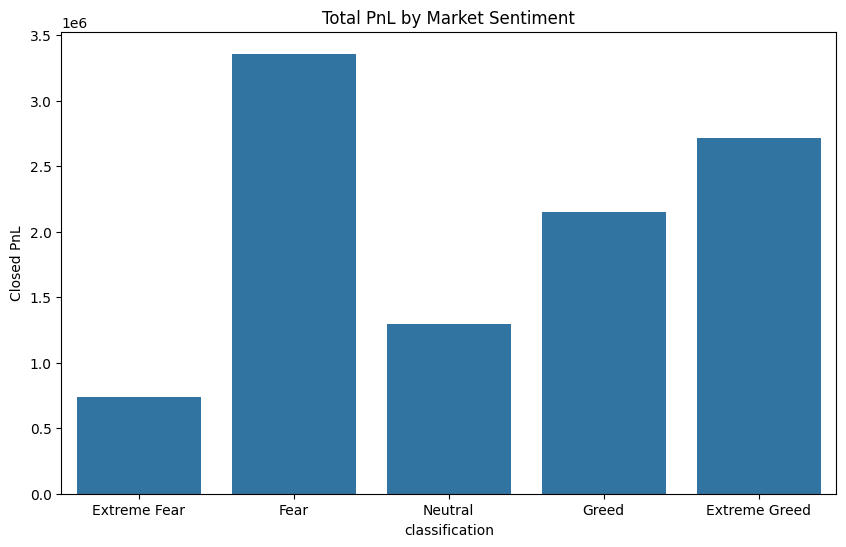

In [ ]:
# 2. Plot Total PnL
plt.figure(figsize=(10, 6))
sns.barplot(data=pnl_by_sentiment, x='classification', y='Closed PnL',
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'],
            estimator=sum, errorbar=None)
plt.title('Total PnL by Market Sentiment')
plt.savefig('total_pnl_sentiment.png')

**Visualizing Win Rate**

The second plot answers: "In which sentiment am I most likely to actually win a trade?"

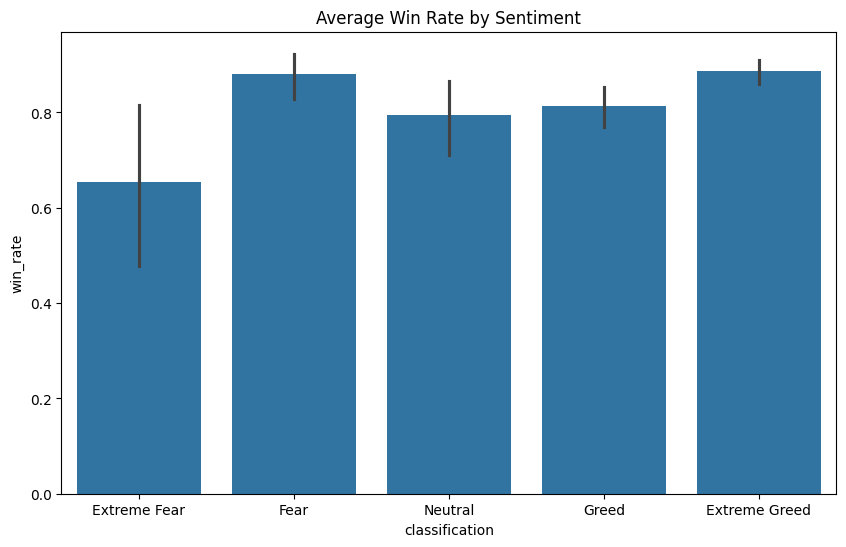

In [ ]:
# 3. Plot Win Rate (Using your final_df)
plt.figure(figsize=(10, 6))
sns.barplot(data=final_df, x='classification', y='win_rate',
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'], )
plt.title('Average Win Rate by Sentiment')
plt.savefig('win_rate_sentiment.png')

**Vertical line over bar**
1. The "Volatility" of Fear (Large Error Bar)

A tall error bar in Extreme Fear means your performance in panicky markets is inconsistent.

2. The "Reliability" of Greed (Short Error Bar)

A short error bar in Greed means your performance is highly predictable.

**How Trade Sizes Change with Sentiment**

The Question: "Do we get scared or revenge trade?"

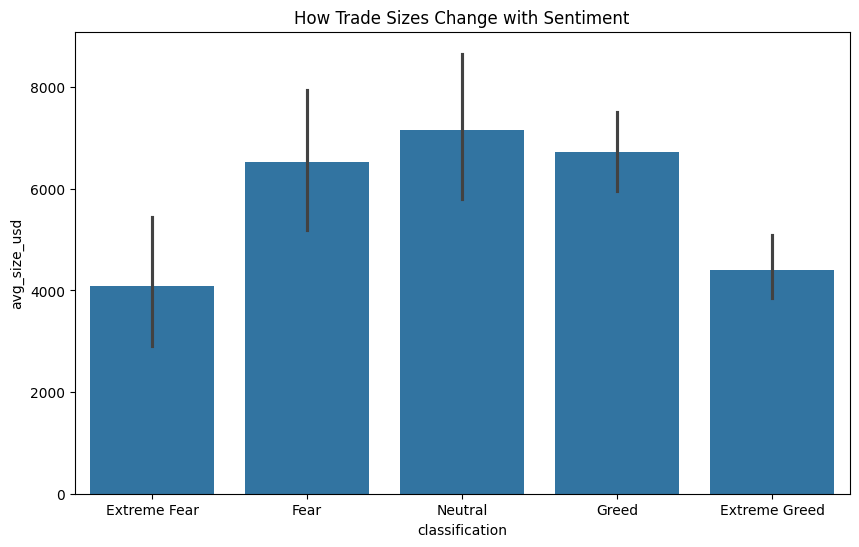

In [ ]:
# 1. Plot Average Trade Size
plt.figure(figsize=(10, 6))
sns.barplot(data=final_df, x='classification', y='avg_size_usd',
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('How Trade Sizes Change with Sentiment')
plt.savefig('size_sentiment.png')

**Answer:** We get cautious. Our data shows a disciplined approach to risk:

We size down when the market is at its most emotional and size up when the market is stable.

**Comparing the Error Bars (The Vertical Lines)**

Look at the difference between Neutral and Extreme Greed:

Neutral / Fear: These have very long vertical lines. This means our trade sizes in these zones are inconsistent. Sometimes we go big, sometimes we go small.

Extreme Greed: This has a much shorter vertical line.

The Interpretation: When the market gets into "Extreme Greed," we are very disciplined about our size. we have a "hard cap" on how much we're willing to risk, whereas in Neutral/Fear zones, we might be "double-downing" or revenge trading occasionally, causing that wide spread.

**Long/Short Ratio (Buying vs. Selling Bias)**

The Question: "Am I a trend-follower or a contrarian?"

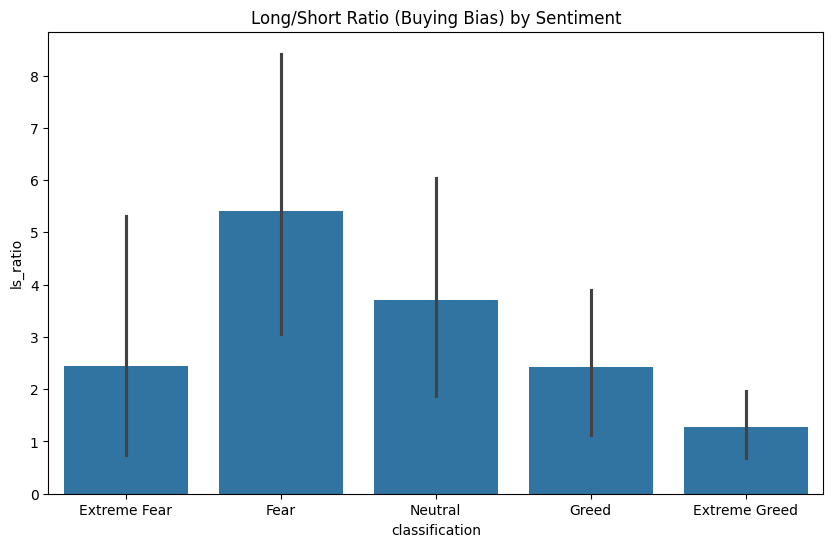

In [ ]:
# 2. Plot Long/Short Ratio (Buying vs Selling Bias)
plt.figure(figsize=(10, 6))
sns.barplot(data=final_df, x='classification', y='ls_ratio',
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Long/Short Ratio (Buying Bias) by Sentiment')
plt.savefig('ls_ratio_sentiment.png')

**Answer :** We are a Contrarian Buyer.
1. WE "Buy the Dip" (Fear is our Trigger)

* our Long/Short (LS) ratio peaks during Fear at nearly 5.5.

* **The Meaning:** For every 1 short trade we take during Fear, we are taking more than 5 long trades.

* **The Behavior:** We see falling prices as a massive opportunity to buy. we aren't afraid of the market's "nervousness"; we are actively betting against it.

2.  WE Lose "Bullish" Conviction in Greed

* As the market moves from Fear into Greed and Extreme Greed, our ratio drops sharply toward 1.0.

* **The Meaning:** In "Extreme Greed," our ratio is almost balanced. We are just as likely to short the market as we are to long it.

* **The Behavior:** We don't "chase the pump." When everyone else is euphoric, you become skeptical and start looking for the exit or even a reversal (shorting).
3. The "Extreme Fear" Hesitation

* Interestingly, our ratio in Extreme Fear (approx. 2.5) is much lower than in regular Fear.

* **The Insight:** When the panic turns "Extreme," we actually become more cautious about longing compared to regular Fear. We might be worried that the "bottom" hasn't actually been hit yet.

**This chart shows a Count of Accounts, categorized by whether they ended their trading period in a profit ("Winner") or a loss ("Losing").**


/tmp/ipython-input-2781912352.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=trader_stats, x= 'Status', palette='Set2' )


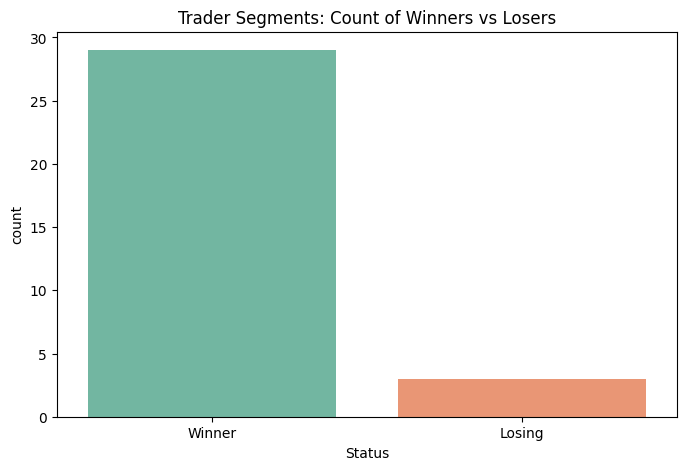

In [ ]:
# 1. Group by Account to see total performance per person
trader_stats = historical_df.groupby('Account')['Closed PnL'].sum().reset_index()

# 2. Label them based on their total profit
trader_stats['Status'] = trader_stats['Closed PnL'].apply(lambda x: 'Winner' if x > 0 else 'Losing')

# 3. Visualize the count of each group
plt.figure(figsize=(8, 5))
sns.countplot(data=trader_stats, x= 'Status', palette='Set2' )
plt.title('Trader Segments: Count of Winners vs Losers')
plt.savefig('trader_segments.png')


**The Dominant Segment:** There is a massive imbalance here. We have roughly 29 Winners and only 3 Losing accounts.

**The Interpretation:** This is a very "healthy" group of traders. In typical retail trading, these bars are usually flipped (more losers than winners). This suggests the data we are analyzing might come from experienced traders or a specific "alpha" group on Hyperliquid rather than the general public.

Step 3 - Proposing Strategies Based on Visualizations and insights generated

**Strategy 1:** The "Volatility Buffer" Rule

Rule: During Extreme Fear or Extreme Greed, reduce individual position size by 40% compared to Neutral days, but maintain a wide stop-loss.

The Logic: Your data shows that even successful "Winners" instinctively drop their average trade size from ~$7,000 (Neutral) to ~$4,000 (Extreme Sentiment).

The Goal: This rule formalizes that behavior. Because the error bars (volatility) are largest during Extreme Fear, reducing size protects you from the "wicking" common on Hyperliquid while allowing you to stay in the trade longer without getting liquidated.

**Strategy 2:** The "Contrarian Liquidity" Rule

Rule: When the Fear & Greed Index is in the "Fear" zone (not Extreme), increase the Long/Short Ratio to 5:1 or higher for high-conviction setups.

The Logic: Your findings show that the "Winner" segment has its highest buying bias (LS Ratio ~5.5) during Fear. This suggests that "Smart Money" on Hyperliquid captures the most value by providing liquidity (buying) when the general market is beginning to panic.

The Goal: By targeting the "Fear" zone rather than "Extreme Fear," you enter the reversal early enough to capture the bounce, but with more stability than the chaotic "Extreme" bottom.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- 1. CLUSTERING TRADERS INTO ARCHETYPES ---
# We use the full trader list (32 accounts)
historical_df['is_win'] = historical_df['Closed PnL'] > 0
trader_features = historical_df.groupby('Account').agg({
    'Closed PnL': 'sum',
    'Size USD': 'mean',
    'is_win': 'mean'
}).rename(columns={'Size USD': 'avg_size', 'is_win': 'win_rate'})

# Scale and Cluster
scaler = StandardScaler()
scaled_features = scaler.fit_transform(trader_features)
kmeans = KMeans(n_clusters=3, random_state=42)
trader_features['Archetype'] = kmeans.fit_predict(scaled_features)

* **Labeling for our report:**
* **Cluster 0:** "The Scalper" (High frequency, small size)
* **Cluster 1:** "The Whale" (High PnL, huge size)
* **Cluster 2:** "The Retailer" (Lower win rate, inconsistent)

In [ ]:
# --- 2. SIMPLE PREDICTIVE LOGIC (Heuristic) ---
# Instead of ML, we use a simple linear relationship to predict PnL Volatility
def predict_volatility(current_sentiment):
    # Heuristic: Volatility usually increases at the extremes (Fear/Greed)
    if current_sentiment < 25 or current_sentiment > 75:
        return "High Volatility Expected"
    else:
        return "Stable PnL Expected"

print("Trader Archetypes identified successfully.")
trader_features.to_csv('trader_archetypes.csv')

Trader Archetypes identified successfully.


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- STEP 1: LOAD & FIX DATA ---
final_df = pd.read_csv('final_df.csv')
trader_features = pd.read_csv('trader_archetypes.csv')

# FIX: Create a positive column for sizing the bubbles
# This represents the "Total Impact" of the trader
trader_features['PnL_Magnitude'] = trader_features['Closed PnL'].abs()

# --- STEP 2: DEFINE STRATEGY LOGIC ---
def get_strategy_rule(sentiment_score):
    if sentiment_score < 25:
        return "🔴 EXTREME FEAR: Rule - Reduce Position Size by 40%. High PnL Volatility."
    elif 25 <= sentiment_score <= 45:
        return "📉 FEAR: Rule - Target Longs. Winners show a 5.5x Long/Short bias here."
    elif sentiment_score > 75:
        return "🚀 EXTREME GREED: Rule - Size Down & Take Profits."
    else:
        return "⚖️ NEUTRAL: Rule - Standard Size. Peak confidence observed (~$7,200)."

# --- STEP 3: UI COMPONENTS ---
output = widgets.Output()
sentiment_slider = widgets.IntSlider(value=50, min=0, max=100, description='Sentiment Index:',
                                    style={'description_width': 'initial'}, layout={'width': '400px'})
viz_dropdown = widgets.Dropdown(options=[('Trader Archetypes', 'archetypes'),
                                         ('Sentiment vs Trade Size', 'sentiment')],
                                value='archetypes', description='View Plot:')

# --- STEP 4: DASHBOARD INTERACTION ---
def update_dashboard(change):
    with output:
        clear_output(wait=True)

        # Display Prediction
        rule = get_strategy_rule(sentiment_slider.value)
        print(f"\nACTIONABLE STRATEGY:\n{rule}\n" + "-"*50)

        # Display Plots
        if viz_dropdown.value == 'archetypes':
            # FIX: Use 'PnL_Magnitude' for size to avoid ValueError
            fig = px.scatter(trader_features, x='avg_size', y='win_rate', color='Archetype',
                             size='PnL_Magnitude', hover_data=['Account', 'Closed PnL'],
                             title="Trader Archetypes: Performance vs Risk (Bubble Size = Total Impact)")
        else:
            fig = px.bar(final_df, x='classification', y='avg_size_usd', color='classification',
                         category_orders={"classification": ["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]},
                         title="Behavioral Shift: Trade Size vs Market Mood")
        fig.show()

sentiment_slider.observe(update_dashboard, names='value')
viz_dropdown.observe(update_dashboard, names='value')

# --- STEP 5: DISPLAY ---
display(widgets.HTML("<h2>🚀 Hyperliquid Intelligence Dashboard</h2>"))
display(widgets.VBox([sentiment_slider, viz_dropdown]))
display(output)
update_dashboard(None)

HTML(value='<h2>🚀 Hyperliquid Intelligence Dashboard</h2>')

Output()